In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.market_api import get_yfinance_time_series
from fitter import Fitter

plt.style.use('default')

In [3]:
def plot_fundings(data):
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(lambda x, pos: x / 1e9)
    sns.barplot(x='announced_on', y='raised_amount_usd', data=data, palette='winter', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_xlabel('')
    ax.set_ylabel('Capital raised ($B)')

    y = data.raised_amount_usd
    for i, v in enumerate(y):
        ax.text(x=i-0.20, y=v/y.iloc[i] + min(y)/2.5,
                s=int(y.iloc[i] / 1e9),
                rotation=90, fontsize=12, weight='regular')
    plt.show()

# Global stats

In [4]:
rounds = pd.read_csv('../../data/crunchbase/funding_rounds.csv')
rounds.announced_on = pd.to_datetime(rounds.announced_on, errors='coerce')
rounds['year'] = rounds.announced_on.dt.year

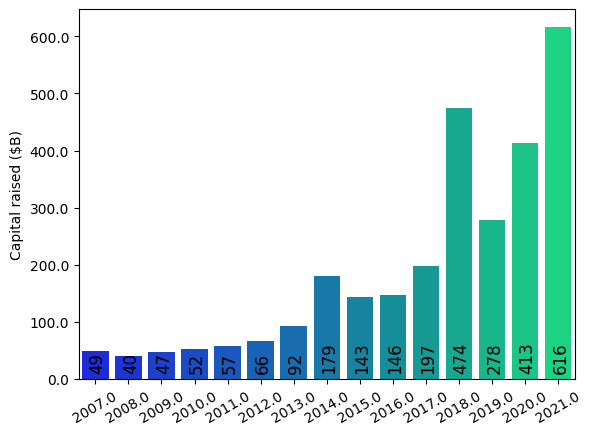

In [5]:
start = 2007
end = 2021

fundings_per_year_US = rounds[(rounds.announced_on.dt.year >= start)
                              & (rounds.announced_on.dt.year <= end)
                              & (rounds.country_code == "USA")]
fundings_per_year_US = fundings_per_year_US[['announced_on', 'raised_amount_usd']]
fundings_per_year_US = fundings_per_year_US.groupby(rounds.announced_on.dt.year).sum().reset_index()

plot_fundings(fundings_per_year_US)

In [3]:
orgs = pd.read_csv('../../data/crunchbase/organizations.csv')

In [7]:
stages = {
    'early stage': ['angel', 'seed', 'pre_seed', 'product_crowdfunding', 'equity_crowdfunding', 'initial_coin_offering', 'non_equity_assistance'],
    'mid stage': ['series_a', 'series_b', 'corporate_round'],
    'late stage': ['series_c', 'series_d', 'series_e', 'series_f', 'series_i', 'series_g', 'series_h', 'series_j'],
    'other': ['post_ipo_equity', 'post_ipo_secondary', 'post_ipo_debt', 'series_unknown', 'undisclosed', 'debt_financing', 'grant', 'convertible_note', 'secondary_market']
}

stage_map = {}
for k, v in stages.items():
    for x in v:
        stage_map[x] = k

rounds['stage'] = rounds.investment_type.map(stage_map)

In [8]:
print(rounds[rounds.investment_type == 'series_b'][['raised_amount_usd', 'post_money_valuation_usd']].dropna().median())
print(rounds[rounds.investment_type == 'series_c'][['raised_amount_usd', 'post_money_valuation_usd']].dropna().median())
print(rounds[rounds.investment_type == 'corporate_round'][['raised_amount_usd', 'post_money_valuation_usd']].dropna().median())

raised_amount_usd            31651216.0
post_money_valuation_usd    200000000.0
dtype: float64
raised_amount_usd            80000000.0
post_money_valuation_usd    650000000.0
dtype: float64
raised_amount_usd            32123560.0
post_money_valuation_usd    268814795.0
dtype: float64


In [9]:
start = 2007
end = 2021

fundings_per_year_stage = rounds[(rounds.announced_on.dt.year >= start)
                                 & (rounds.announced_on.dt.year <= end)
                                 & (rounds.country_code == "USA")]
fundings_per_year_stage = fundings_per_year_stage[['year', 'raised_amount_usd', 'stage']].dropna()
fundings_per_year_stage = fundings_per_year_stage.groupby(['year', 'stage']).sum().reset_index()
fundings_per_year_stage = fundings_per_year_stage[fundings_per_year_stage.stage != 'other']
fundings_per_year_stage.year = fundings_per_year_stage.year.astype(int)

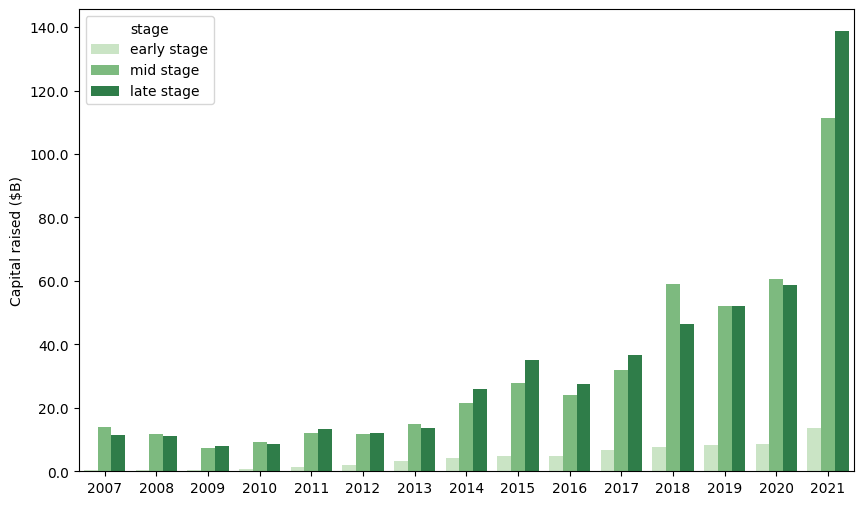

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
ax.yaxis.set_major_formatter(lambda x, pos: x / 1e9)
sns.barplot(x="year", y="raised_amount_usd", hue="stage", hue_order=['early stage', 'mid stage', 'late stage'], data=fundings_per_year_stage, ax=ax, palette='Greens')
ax.set_xlabel('')
ax.set_ylabel('Capital raised ($B)')
# sns.set(font_scale = 1.2)
plt.savefig('figures/capital_raised.pdf')
plt.show()

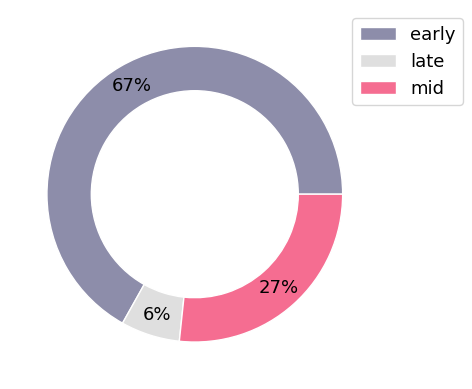

In [11]:
plt.pie(rounds.groupby('stage').size().drop('other'),
        radius=1, wedgeprops=dict(width=0.3, edgecolor='w'), textprops={'fontsize':13},
        colors=['#8D8DAA', '#DFDFDF', '#F56D91'], autopct='%.0f%%', pctdistance=0.85)
plt.legend(['early', 'late', 'mid'], bbox_to_anchor=(0.75, 0, 0.5, 1), fontsize=13)
plt.savefig('figures/total_rounds_per_stage.pdf')

In [12]:
rounds.groupby('stage').size()

stage
early stage    212155
late stage      20489
mid stage       84611
other          159018
dtype: int64

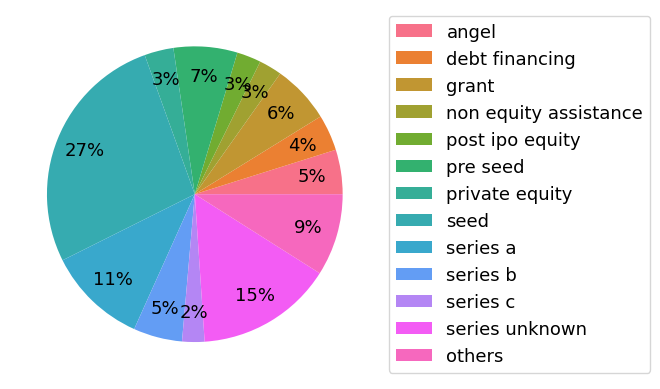

In [13]:
cb_investments = rounds.groupby('investment_type').size() / rounds.shape[0]
cb_investments['others'] = cb_investments[cb_investments < 0.02].sum()
cb_investments = cb_investments[cb_investments >= 0.02]
cb_investments.index = pd.Series(cb_investments.index).apply(lambda s: s.replace('_', ' '))
plt.pie(cb_investments, autopct='%.0f%%', pctdistance=0.8, colors=sns.color_palette("husl", cb_investments.size), textprops={'fontsize':13},)
plt.legend(cb_investments.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=13)
plt.savefig('figures/crunchbase_rounds.pdf')
plt.show()

# Industry breakdown

In [24]:
orgs = pd.read_csv('../../data/crunchbase/organizations.csv')
cats = orgs[orgs.uuid.isin(rounds.org_uuid)][['uuid', 'category_groups_list']].dropna()
cats.category_groups_list = cats.category_groups_list.apply(lambda x: x.split(','))
cats.columns = ['org_uuid', 'category']

In [26]:
orgs['category_groups_list'].dropna().apply(lambda x: x.split(',')).explode().unique()

array(['Content and Publishing', 'Internet Services',
       'Media and Entertainment', 'Sales and Marketing',
       'Administrative Services', 'Information Technology', 'Other',
       'Privacy and Security', 'Software', 'Financial Services',
       'Lending and Investments', 'Hardware', 'Commerce and Shopping',
       'Community and Lifestyle', 'Mobile', 'Video', 'Advertising',
       'Messaging and Telecommunications', 'Music and Audio',
       'Data and Analytics', 'Design', 'Science and Engineering',
       'Sports', 'Navigation and Mapping', 'Biotechnology',
       'Professional Services', 'Energy', 'Education', 'Health Care',
       'Artificial Intelligence', 'Gaming', 'Payments', 'Platforms',
       'Apps', 'Food and Beverage', 'Consumer Electronics',
       'Agriculture and Farming', 'Natural Resources', 'Sustainability',
       'Travel and Tourism', 'Transportation', 'Events', 'Manufacturing',
       'Real Estate', 'Consumer Goods', 'Government and Military',
       'Clothin

In [27]:
big4 = [
    'Tech',
    'Tech',
    'Other',
    'Retail',
    'Other',
    'Tech',
    'Other',
    'Tech',
    'Tech',
    'Tech',
    'Tech',
    'Tech',
    'Retail',
    'Tech',
    'Tech',
    'Tech',
    'Retail',
    'Tech',
    'Tech',
    'Tech',
    'Tech',
    'Tech',
    'Other',
    'Tech',
    'Health',
    'Other',
    'Other',
    'Tech',
    'Health',
    'Tech',
    'Tech',
    'Tech',
    'Tech',
    'Tech',
    'Health',
    'Tech',
    'Health',
    'Health',
    'Health',
    'Retail',
    'Other',
    'Other',
    'Retail',
    'Other',
    'Retail',
    'Other',
    'Retail',
]


summarized_cats = [
    'Media',
    'Software',
    'IT Hardware',
    'Consumer P&S',
    'Consumer P&S',
    'Media',
    'Software',
    'Software',
    'Media',
    'Software',
    'Consumer P&S',
    'Other',
    'Commercial P&S',
    'Software',
    'Media',
    'IT Hardware',
    'Other',
    'Other',
    'Commercial P&S',
    'Commercial P&S',
    'Biotech',
    'Other',
    'Healthcare',
    'Other',
    'Consumer P&S',
    'Consumer P&S',
    'Software',
    'Software',
    'Consumer P&S',
    'IT Hardware',
    'Software',
    'Other',
    'Commercial P&S',
    'Commercial P&S',
    'Other',
    'Energy',
    'Other',
    'Commercial P&S',
    'Consumer P&S',
    'Other',
    'Energy',
    'Software',
    'Energy',
    'Other'
]

In [28]:
from tqdm import tqdm
tqdm.pandas()

def get_most_relevant_cat(categories):
    mapped = cat_freqs[cat_freqs.index.isin(categories)]
    return categories[np.argmax(mapped)]

cat_freqs = cats.category.explode().value_counts() / cats.category.size
cats.category = cats.category.progress_apply(get_most_relevant_cat)

rounds['category'] = rounds.org_uuid.map(cats.set_index('org_uuid').to_dict()['category'])
rounds['meta_cat'] = rounds.category.map(dict(zip(rounds.category.unique(), big4)))

100%|██████████| 73893/73893 [00:16<00:00, 4355.91it/s]


In [18]:
100 * rounds[['name', 'category', 'meta_cat']].groupby('meta_cat').size() / rounds.shape[0]

meta_cat
Health     6.198977
Other     11.103477
Retail    17.248788
Tech      65.448758
dtype: float64

In [19]:
path = '../../data/data.csv'
returns = pd.read_csv(path, low_memory=False)

cat_org_map = rounds[rounds.org_uuid.isin(rounds.org_uuid.unique())][['org_uuid', 'category', 'meta_cat']]
cat_org_map = cat_org_map.set_index('org_uuid')

returns.seg_num = returns.company_num.map(cat_org_map.category.to_dict())
returns.group_num = returns.company_num.map(cat_org_map.meta_cat.to_dict())

returns.to_csv(path, index=False)

In [72]:
start = 2007
end = 2021
fundings_per_year_cat = rounds[(rounds.year >= start)
                               & (rounds.year <= end)
                               & (rounds.country_code == 'USA')][['year', 'meta_cat', 'raised_amount_usd']]
fundings_per_year_cat = fundings_per_year_cat.groupby(['year', 'meta_cat']).sum()

In [108]:
pd.options.display.float_format = None
fundings_per_year_cat[fundings_per_year_cat.index.get_level_values('year') == 2021] / 1e9

raised_amount_usd
year   meta_cat                   
2021.0 Health            33.768641
       Other             48.923932
       Retail            63.761197
       Tech             470.029313

In [109]:
from kaleido import *

In [110]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

country_freq = rounds.groupby('country_code').size() / rounds.country_code.size
country_freq['others'] = country_freq[country_freq < 0.02].sum()
country_freq = country_freq[country_freq >= 0.02]
cb_sectors = rounds.groupby('meta_cat').size()

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], horizontal_spacing=0.1)
fig.add_trace(go.Pie(values=country_freq.values, name="Country", labels=country_freq.index,
                     texttemplate = "%{label}<br>(%{percent})"),
              1, 1)
fig.add_trace(go.Pie(values=cb_sectors.values, name="Sector", labels=cb_sectors.index,
                     texttemplate = "%{label}<br>(%{percent})", rotation = 90),
              1, 2)

fig.update_layout(height=500, width=1100,
                  showlegend=False,
                  font={'size':18},
                  margin={'l':0, 'r':0, 't':0, 'b':0})
fig.write_image('figures/crunchbase_country_sectors.pdf')
fig.show()

In [111]:
rounds[(rounds.post_money_valuation_usd > 0)].sort_values(by='org_name')

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,country_code,state_code,...,post_money_valuation_currency_code,investor_count,org_uuid,org_name,lead_investor_uuids,year,stage,category,meta_cat,year_added
488522,23c8c92c-a7b9-43ae-8a29-920a81808e03,Seed Round - #tide®,funding_round,tide-571a-seed--23c8c92c,https://www.crunchbase.com/funding_round/tide-...,57863.0,2022-06-10 05:50:18,2022-06-10 05:50:18,CHE,NaN,...,USD,NaN,2b424784-2a87-43be-aaf8-8d160b5f571a,#tide®,NaN,2020.0,early stage,Manufacturing,Tech,2022
453294,0f340ff4-4489-4e98-858b-6a11db173ff6,Seed Round - #walk15,funding_round,walk15-229d-seed--0f340ff4,https://www.crunchbase.com/funding_round/walk1...,16539.0,2022-01-19 15:18:26,2022-01-19 15:18:26,LTU,NaN,...,EUR,4.0,46c4ee6e-fdda-4bb3-925d-eb8533bc229d,#walk15,NaN,2021.0,early stage,Apps,Retail,2022
299051,6bbaa3b1-813e-441c-832f-c095c0f7b8c7,Secondary Market - &pizza,funding_round,pizza-4-secondary-market--6bbaa3b1,https://www.crunchbase.com/funding_round/pizza...,91875.0,2020-03-03 22:30:46,2020-03-03 22:30:46,USA,DC,...,USD,1.0,e098354a-5d4e-9365-0298-c8649e2b4861,&pizza,8487d047-1992-47db-866f-6607accf43de,2019.0,other,Food and Beverage,Health,2020
299050,14acdcf0-fff9-45e3-9cf7-72f3cabcb9a9,Secondary Market - &pizza,funding_round,pizza-4-secondary-market--14acdcf0,https://www.crunchbase.com/funding_round/pizza...,294193.0,2020-03-03 22:28:27,2020-03-03 22:28:27,USA,DC,...,USD,1.0,e098354a-5d4e-9365-0298-c8649e2b4861,&pizza,8487d047-1992-47db-866f-6607accf43de,2019.0,other,Food and Beverage,Health,2020
252964,a52df74f-84d3-440c-ae0e-e2ad6c70ddfe,Seed Round - .nanobile,funding_round,nanobile-seed--a52df74f,https://www.crunchbase.com/funding_round/nanob...,383807.0,2019-04-23 19:14:34,2019-04-23 19:14:34,SRB,NaN,...,EUR,NaN,0ecd89e0-5ffb-42c5-8d5f-42bd0db3602f,.nanobile,NaN,2019.0,early stage,Artificial Intelligence,Tech,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321607,a8dddeb4-34bd-4332-8372-e36e8d8cf85f,Pre Seed Round - ЭМИИА ИИ (EMIIA.AI),funding_round,emiia-ai-pre-seed--a8dddeb4,https://www.crunchbase.com/funding_round/emiia...,417091.0,2020-07-02 09:47:20,2020-07-02 09:47:20,RUS,NaN,...,USD,1.0,720e888f-8a3d-48f5-bed6-26cb42ba0d7c,ЭМИИА ИИ (EMIIA.AI),b35e276a-8a49-488d-b084-671c5b1c64d8,2017.0,early stage,Artificial Intelligence,Tech,2020
407518,508d7832-d44e-4b32-93dd-af9ef7a2b2ae,Seed Round - ЭМИИА ИИ (EMIIA.AI),funding_round,emiia-ai-seed--508d7832,https://www.crunchbase.com/funding_round/emiia...,329213.0,2021-06-14 13:21:28,2021-06-14 13:21:28,RUS,NaN,...,USD,1.0,720e888f-8a3d-48f5-bed6-26cb42ba0d7c,ЭМИИА ИИ (EMIIA.AI),1dbc1bd5-7f71-6862-ad39-2c1fd1e16f56,2021.0,early stage,Artificial Intelligence,Tech,2021
186552,b9642be8-95a3-4d5b-a32d-342f92b4f0f5,Equity Crowdfunding - ​​Zenz Organic,funding_round,zenz-organic-equity-crowdfunding--b9642be8,https://www.crunchbase.com/funding_round/zenz-...,214227.0,2018-01-04 04:55:42,2018-02-12 23:37:22,DNK,NaN,...,DKK,NaN,85700750-9e29-473b-a5ac-30dbec63e071,​​Zenz Organic,NaN,2018.0,early stage,Consumer Goods,Tech,2018
224909,76591133-f78b-4d61-b035-e91396e64441,Angel Round - 停車大聲公 PKLOT Inc,funding_round,停車大聲公-pklot-inc-angel--76591133,https://www.crunchbase.com/funding_round/停車大聲公...,168541.0,2018-09-16 04:07:34,2018-09-16 04:07:34,TWN,NaN,...,USD,2.0,168e52e0-b9f5-45be-8792-f5c1d96c68d2,停車大聲公 PKLOT Inc,9f85686a-94c1-4440-9847-85cadf9e42b4,2016.0,early stage,Apps,Retail,2018


In [112]:
capitaliq = pd.read_excel('../../data/pmv_not_na.xls', skiprows=6, header=1, na_values='-')
capitaliq.columns = ['announced_on', 'name', 'exchange',
                     'investors', 'status',
                     'amount_raised_usd',
                     'pre_money_valuation',
                     'post_money_valuation',
                     'country', 'round_type',
                     'industry_classification',
                     'Excel Company ID [Target/Issuer]', 'CIK [Target/Issuer]',
                     'SIC Codes (Primary Code Only) [Target/Issuer]']
capitaliq = capitaliq.drop(columns=['exchange', 'Excel Company ID [Target/Issuer]', 'CIK [Target/Issuer]', 'SIC Codes (Primary Code Only) [Target/Issuer]'])
capitaliq

,announced_on,name,investors,status,amount_raised_usd,pre_money_valuation,post_money_valuation,country,round_type,industry_classification
0,2021-09-06,Alif Bank OJSC,Jefferson Capital Holdings Llc,Closed,8.00,92.00,100.00,NaN,Growth,Banks (Primary); Banks (Primary); Financials (...
1,2021-10-13,"Dexterity, Inc.",Kleiner Perkins Caufield & Byers; Presidio STX...,Closed,140.00,1260.00,1400.00,United States,Series B,Capital Goods (Primary); Industrial Machinery ...
2,2015-11-25,"Seaport Diagnostics, Inc.",180 Degree Capital Corp. (NasdaqGM:TURN); DEFT...,Closed,12.50,10.99,23.49,United States,Series A,Biotechnology (Primary); Biotechnology (Primar...
3,2018-06-12,"Seaport Diagnostics, Inc.",Laboratory Corporation of America Holdings (NY...,Closed,26.17,67.26,93.43,United States,Series B,Biotechnology (Primary); Biotechnology (Primar...
4,2001-01-31,"(X,Y,Z) Imaging Inc.",NaN,Effective,1.88,2.64,4.52,NaN,Series A,Commercial and Professional Services (Primary)...
...,...,...,...,...,...,...,...,...,...,...
9995,2017-06-08,"Hangzhou DT Dream Technology Co., Ltd.",Alibaba Group Holding Limited (NYSE:BABA); Zhe...,Closed,110.29,892.35,1002.65,China,Series A,Information Technology (Primary); Infrastructu...
9996,2019-09-26,"Hangzhou DT Dream Technology Co., Ltd.","Zheshang Venture Capital Co., Ltd; Zhejiang St...",Closed,84.12,1415.88,1500.00,China,Series B,Information Technology (Primary); Infrastructu...
9997,2015-10-29,"Hangzhou Duiba Network Technology Co., Ltd.",NaN,Closed,4.25,27.22,31.47,NaN,Series B,Information Technology (Primary); Information ...
9998,2014-08-31,"Hangzhou Enniu Network Technology Co., Ltd.","GGV Capital, LLC; JD.com, Inc. (NasdaqGS:JD); ...",Closed,50.00,250.00,300.00,NaN,Series B,Application Software (Primary); Information Te...


In [113]:
rnd_types = ['angel', 'series_a', 'series_b', 'seed', 'growth']
growth = ['series_c', 'series_d', 'series_e', 'series_f', 'series_i', 'series_g', 'series_h', 'series_j']
rounds.investment_type = rounds.investment_type.apply(lambda x: 'growth' if x in growth else x)
rounds_activity = rounds[(rounds.announced_on.dt.year > 2000) & (rounds.investment_type.isin(rnd_types))].copy()
rounds_activity['count'] = np.ones_like(rounds_activity.index)
rounds_activity = rounds_activity.groupby([rounds_activity.announced_on.dt.year, rounds_activity.announced_on.dt.month, rounds_activity.investment_type]).sum()
rounds_activity = rounds_activity[['raised_amount_usd', 'count']]
rounds_activity.index.names = ['year', 'month', 'round_type']
rounds_activity.reset_index(inplace=True)

In [114]:
rounds_activity['period'] = rounds_activity.apply(lambda i: str(i.year) + '-' + str(i.month), axis=1)
rounds_activity.period = pd.to_datetime(rounds_activity.period, format='%Y-%m')
rounds_activity = rounds_activity[rounds_activity.period < '2022-06-01']
rounds_activity.columns = ['year', 'month', 'round_type', 'raised_amount_usd', 'count', 'period']

In [115]:
rounds_activity

,year,month,round_type,raised_amount_usd,count,period
0,2001,1,angel,0.000000e+00,3,2001-01-01
1,2001,1,growth,8.926000e+08,25,2001-01-01
2,2001,1,seed,9.375997e+06,36,2001-01-01
3,2001,1,series_a,7.155459e+08,80,2001-01-01
4,2001,1,series_b,1.255740e+09,64,2001-01-01
...,...,...,...,...,...,...
1275,2022,5,angel,6.481944e+07,82,2022-05-01
1276,2022,5,growth,1.089444e+10,116,2022-05-01
1277,2022,5,seed,2.660346e+09,824,2022-05-01
1278,2022,5,series_a,5.286069e+09,345,2022-05-01


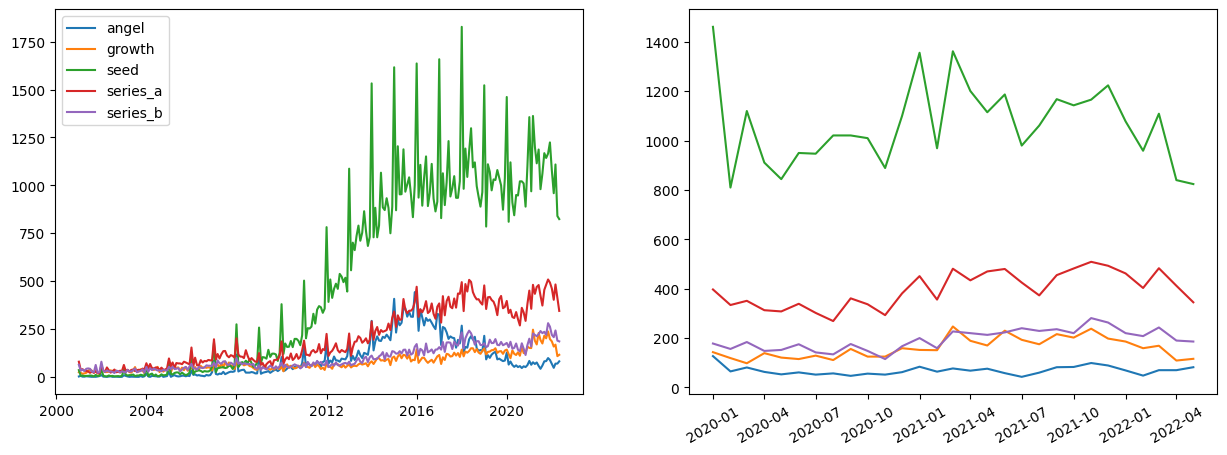

In [81]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for tp in rounds_activity.round_type.unique():
    axs[0].plot(rounds_activity[rounds_activity.round_type == tp][['period', 'count']].set_index('period'), label=tp)
axs[0].legend()
for tp in rounds_activity.round_type.unique():
    axs[1].plot(rounds_activity[(rounds_activity.period.dt.year > 2019) & (rounds_activity.round_type == tp)][['period', 'count']].set_index('period'), label=tp)
plt.xticks(rotation=30)
plt.show()

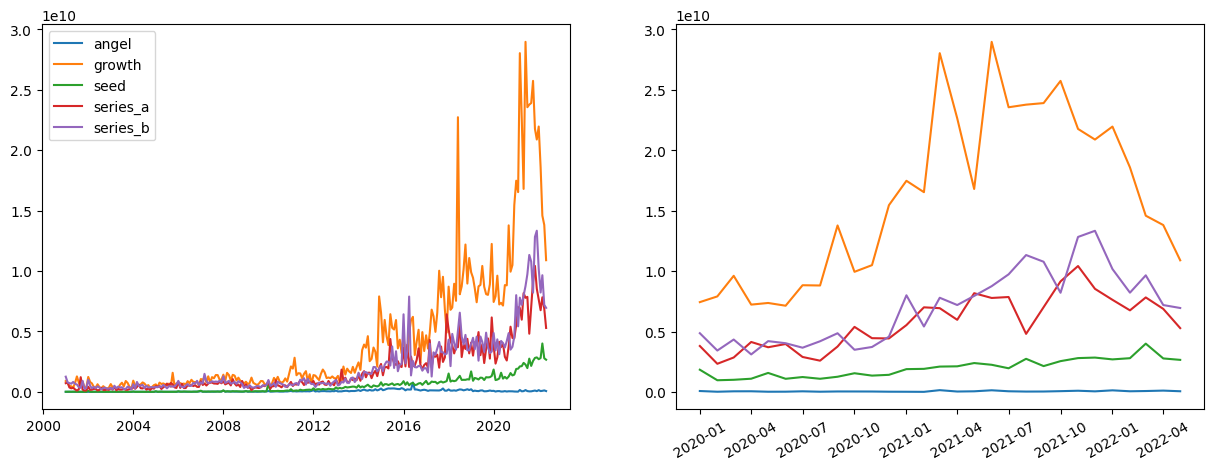

In [82]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for tp in rounds_activity.round_type.unique():
    axs[0].plot(rounds_activity[rounds_activity.round_type == tp][['period', 'raised_amount_usd']].set_index('period'), label=tp)
axs[0].legend()
for tp in rounds_activity.round_type.unique():
    axs[1].plot(rounds_activity[(rounds_activity.period.dt.year > 2019) & (rounds_activity.round_type == tp)][['period', 'raised_amount_usd']].set_index('period'), label=tp)
plt.xticks(rotation=30)
plt.show()

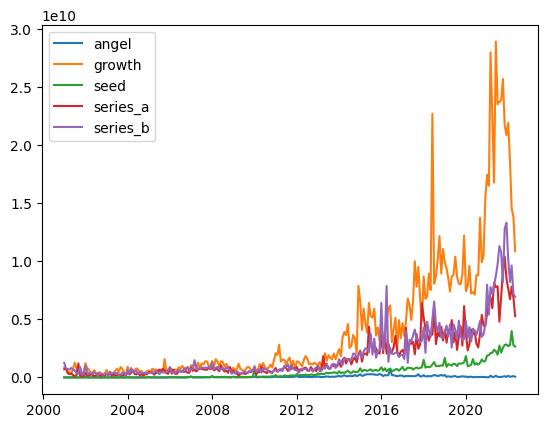

In [83]:
for tp in rounds_activity.round_type.unique():
    plt.plot(rounds_activity[rounds_activity.round_type == tp][['period', 'raised_amount_usd']].set_index('period'), label=tp)
    plt.legend()

<AxesSubplot:ylabel='Count'>

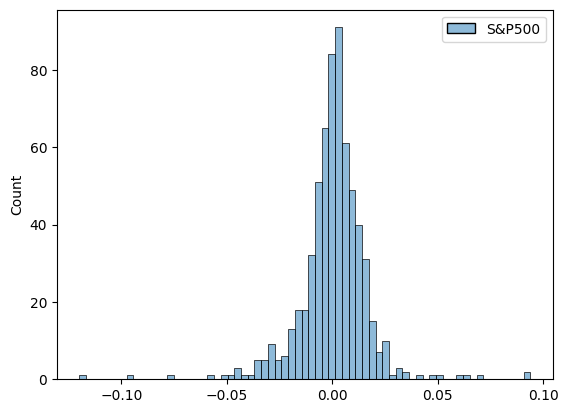

In [84]:
sp500 = get_yfinance_time_series('^GSPC', start=2020, end=None)
daily_ret = sp500.pct_change()
daily_ret = daily_ret.reset_index()
daily_ret.columns=['date', 'S&P500']
sns.histplot(data=daily_ret)

In [23]:
ipos = pd.read_csv('../../data/crunchbase/ipos.csv')
acqs = pd.read_csv('../../data/crunchbase/acquisitions.csv')

In [24]:
prop = orgs.groupby(orgs.status).size() / orgs.shape[0]
prop = prop.map('{:.2%}'.format)
prop

status
acquired      5.37%
closed        6.75%
ipo           1.96%
operating    85.92%
dtype: object

In [25]:
big_countries = rounds.groupby('country_code').size()
big_countries = big_countries[big_countries > 2000]

df = rounds[rounds.country_code.isin(big_countries.index)]
df.groupby('country_code').mean().post_money_valuation_usd.sort_values().dropna()[-10:]

country_code
ISR    3.827132e+08
FRA    4.649084e+08
DEU    7.083067e+08
USA    7.524895e+08
SWE    7.693192e+08
JPN    8.016059e+08
NLD    9.806836e+08
KOR    1.071824e+09
IND    1.492001e+09
CHN    3.740650e+09
Name: post_money_valuation_usd, dtype: float64

In [26]:
df.groupby('meta_cat').mean().post_money_valuation_usd.sort_values().dropna()[-10:].astype(int)

meta_cat
Health     298189514
Other      386551975
Tech       761320999
Retail    1020301618
Name: post_money_valuation_usd, dtype: int64

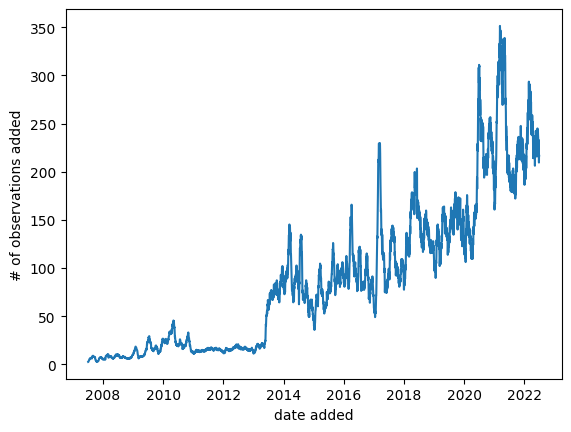

In [28]:
rounds['year_added'] = pd.to_datetime(rounds.created_at).dt.year

s = pd.to_datetime(rounds.created_at)
added_num = s.groupby(s.dt.floor('d')).size()

sns.lineplot(x=added_num.index, y=added_num.rolling(30).mean())
plt.xlabel('date added')
plt.ylabel('# of observations added')
plt.savefig('figures/date_added.pdf')

# Specification analysis

/var/folders/9g/9p32rxp10c37hppq5lydn44c0000gn/T/ipykernel_80322/2238396604.py:1: DtypeWarning:

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


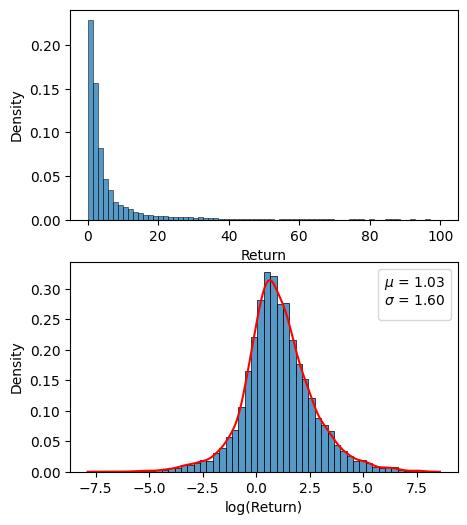

In [89]:
complete = pd.read_csv('../../data/data.csv')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,6))
sns.histplot(complete[complete.return_usd < 100].return_usd, ax=axs[0], bins=70, stat="density")
sns.histplot(np.log(complete.return_usd.dropna()), bins=50, stat="density", ax=axs[1])
sns.kdeplot(np.log(complete.return_usd.dropna()), color="r", ax=axs[1])
axs[0].set_xlabel('Return')
axs[1].set_xlabel('log(Return)')
axs[1].legend(title=f'$\mu$ = {np.log(complete.return_usd.dropna()).mean():.2f}\n$\sigma$ = {np.log(complete.return_usd.dropna()).std():.2f}')
plt.savefig('figures/returns.pdf')

In [90]:
original = pd.read_csv('../../data/crunchbase/funding_rounds.csv')
print(f'Missing PMVs: {original.post_money_valuation_usd.isna().sum() / original.shape[0] * 100:.2f}% ({original.post_money_valuation_usd.isna().sum()})')
print(f'Available PMVs: {original.post_money_valuation_usd.notna().sum() / original.shape[0] * 100:.2f}% ({original.post_money_valuation_usd.notna().sum()})')

Missing PMVs: 94.53% (465022)
Available PMVs: 5.47% (26914)


In [96]:
returns = pd.read_csv('../../data/data_nopred.csv')
ret_sort = np.log(returns.return_usd.dropna())

,sumsquare_error,aic,bic,kl_div
johnsonsu,$0.09,$755.09,"$-8,355.08",$inf
laplace_asymmetric,$0.11,$749.79,"$-8,239.08",$inf
skewcauchy,$0.13,$700.30,"$-8,072.09",$inf
johnsonsb,$0.31,$866.65,"$-7,267.84",$inf


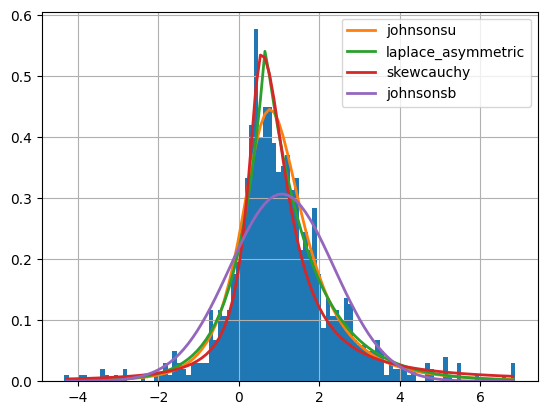

In [97]:
f = Fitter(ret_sort, distributions=['johnsonsu', 'johnsonsb', 'laplace_asymmetric', 'skewcauchy'])
f.fit()
f.summary()

In [98]:
from scipy.stats import norm, johnsonsu

# data
count, bins_count = np.histogram(ret_sort, bins=500)
cdf_ret = np.cumsum(count / sum(count))
# normal
loc_norm, scale_norm = norm.fit(ret_sort)
cdf_th = norm.cdf(bins_count[1:], loc_norm, scale_norm)
# SSSSUUUUU
a, b, loc_su, scale_su = f.get_best()['johnsonsu'].values()
cdf_th_su = johnsonsu.cdf(bins_count[1:], a, b, loc_su, scale_su)


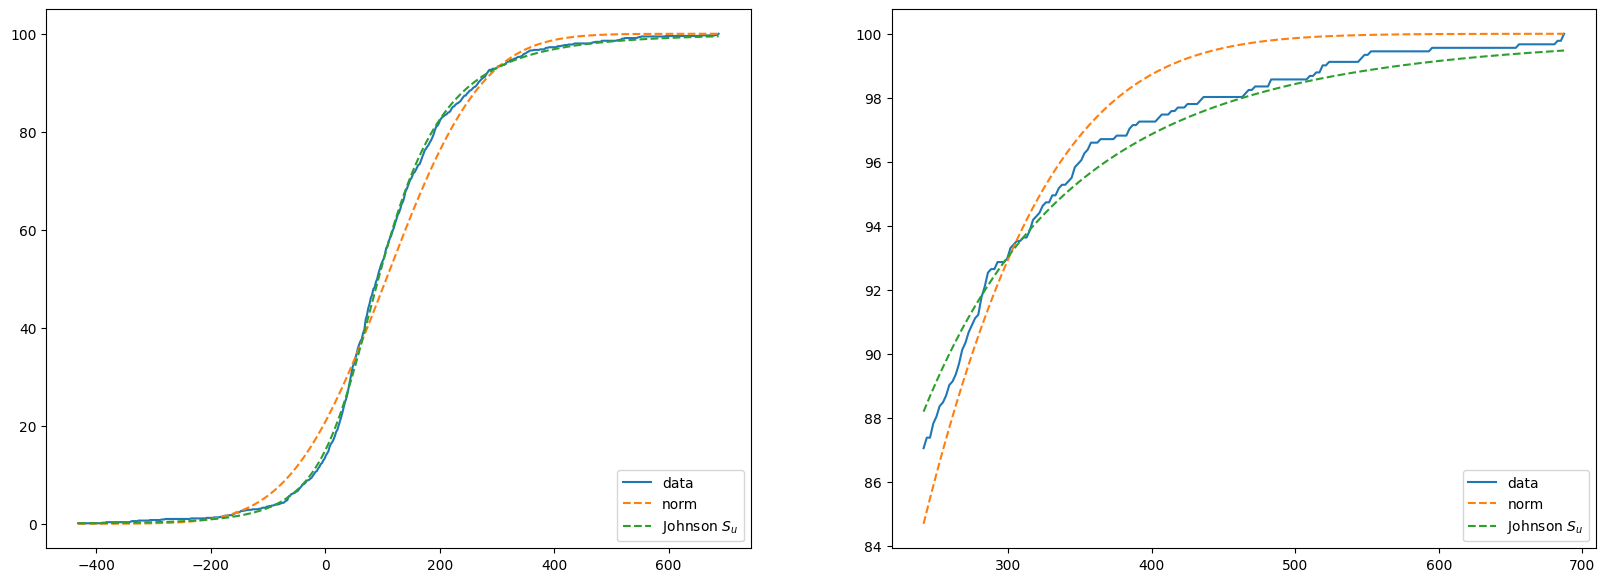

In [99]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

axs[0].plot(bins_count[1:] * 100, cdf_ret * 100, label="data")
axs[0].plot(bins_count[1:] * 100, cdf_th * 100, '--', label=f"norm")
axs[0].plot(bins_count[1:] * 100, cdf_th_su * 100, '--', label=f"Johnson $S_u$")
axs[0].legend(loc='lower right')

axs[1].plot(bins_count[301:] * 100, cdf_ret[300:] * 100, label="data")
axs[1].plot(bins_count[301:] * 100, cdf_th[300:] * 100, '--', label=f"norm")
axs[1].plot(bins_count[301:] * 100, cdf_th_su[300:] * 100, '--', label=f"Johnson $S_u$")
axs[1].legend(loc='lower right')
plt.show()

In [100]:
rets = pd.read_csv('../../data/data.csv', low_memory=False).return_usd.dropna()
log_rets = np.log(rets)

,sumsquare_error,aic,bic,kl_div
johnsonsu,$0.01,$853.43,"$-121,339.94",$inf
laplace_asymmetric,$0.02,$832.95,"$-113,501.44",$inf
skewcauchy,$0.05,$754.83,"$-106,612.37",$inf
johnsonsb,$0.07,"$1,028.36","$-104,707.04",$inf


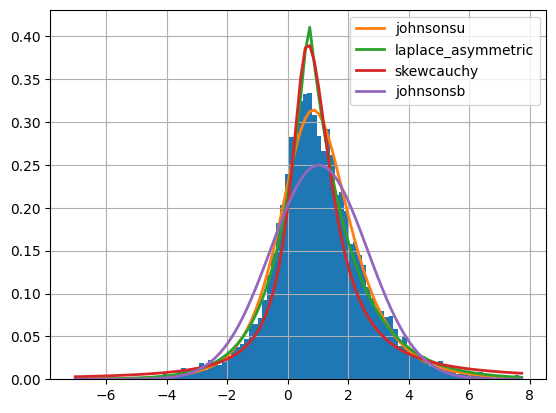

In [101]:
f = Fitter(log_rets, distributions=['johnsonsu', 'johnsonsb', 'laplace_asymmetric', 'skewcauchy'])
f.fit()
f.summary()

In [4]:
from scipy.stats import norm, johnsonsu, logistic

# data
count, bins_count = np.histogram(log_rets, bins=500)
cdf_ret = np.cumsum(count / sum(count))
# normal
loc_norm, scale_norm = norm.fit(log_rets)
cdf_th = norm.cdf(bins_count[1:], loc_norm, scale_norm)
# SSSSUUUUU
a, b, loc_su, scale_su = f.get_best()['johnsonsu'].values()
cdf_th_su = johnsonsu.cdf(bins_count[1:], a, b, loc_su, scale_su)


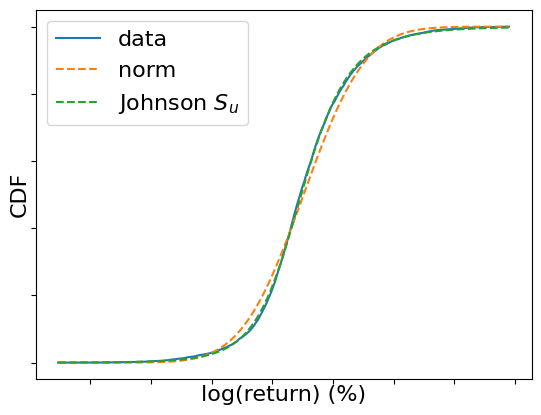

In [103]:
plt.plot(bins_count[1:] * 100, cdf_ret, label="data")
plt.plot(bins_count[1:] * 100, cdf_th, '--', label=f"norm")
plt.plot(bins_count[1:] * 100, cdf_th_su, '--', label=f"Johnson $S_u$")
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('log(return) (%)', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.tick_params(labelleft=False, labelbottom=False, )
plt.savefig('figures/cdf_logret.pdf')
plt.show()

In [5]:
returns = pd.read_csv('../../data/data_nopred.csv', low_memory=False)
# returns = returns[returns.exit_value < 1e10]
exit_val = np.log(returns.exit_value.dropna())

f = Fitter(exit_val, distributions=['logistic'])
f.fit()


count, bins_count = np.histogram(exit_val, bins=100)
cdf_exit = np.cumsum(count / sum(count))

loc_lo, scale_lo = f.get_best()['logistic'].values()
cdf_lo = logistic.cdf(bins_count[1:], loc_lo, scale_lo)

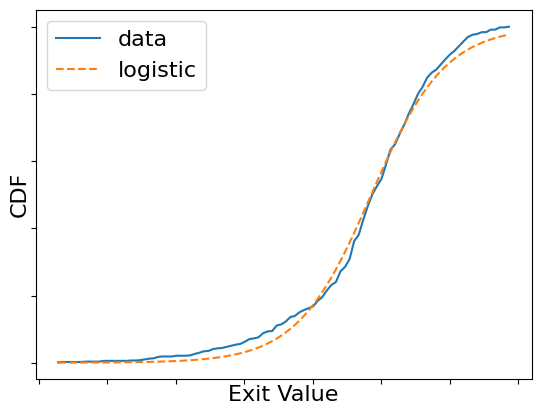

In [6]:

plt.plot(bins_count[1:], cdf_exit, label="data")
plt.plot(bins_count[1:], cdf_lo, '--', label=f"logistic")

plt.tick_params(labelleft=False, labelbottom=False, )
plt.ylabel('CDF', fontsize=16)
plt.xlabel('Exit Value', fontsize=16)
plt.legend(prop={'size': 16})
plt.savefig('figures/cdf_exit.pdf')


# Simulation results

In [2]:
def draw_simulation_graph(prob_exit, prob_bankrupt, prob_private, from_date='2010-01-01'):
    returns = pd.read_csv('../../data/data.csv', low_memory=False)
    returns.round_date = pd.to_datetime(returns.round_date, errors='coerce')
    returns.exit_date = pd.to_datetime(returns.exit_date, errors='coerce')
    after = (returns.round_date >= pd.to_datetime(from_date)) & ((returns.exit_date >= pd.to_datetime(from_date)) | returns.exit_date.isna())
    returns = returns[after].reset_index(drop=True)
    returns['since_round'] = (returns.exit_date - returns.round_date)
    returns = returns.dropna(subset=['since_round'])

    fig, ax = plt.subplots()

    count, bins_count = np.histogram(returns[(returns.exit_type==1) | (returns.exit_type==2)].since_round.dt.days, bins=100)
    pct_exit = returns[(returns.exit_type==1) | (returns.exit_type==2)].shape[0] / returns.shape[0]
    cdf_exit = np.cumsum(count / sum(count)) * pct_exit
    p1=ax.plot(bins_count[1:], cdf_exit, linewidth=0.8, color='black', label='data')

    count, bins_count = np.histogram(returns[returns.exit_type==3].since_round.dt.days, bins=100)
    pct_closed = returns[returns.exit_type==3].shape[0] / returns.shape[0]
    cdf_closed = np.cumsum(count / sum(count)) * pct_closed
    ax.plot(bins_count[1:], cdf_closed, linewidth=0.8, color='black')

    ax.plot(bins_count[1:], 1 - cdf_closed - cdf_exit, linewidth=0.8, color='black')
    ax.set_xlim(bins_count[0], bins_count[-1])
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_xlabel('Time since last funding round')
    ax.set_ylabel('CDF')

    ax2 = ax.twiny()
    p2=ax2.plot(prob_exit.cumsum(), linestyle='--', linewidth=0.8, color='black', label='model')
    ax2.plot(prob_bankrupt.cumsum(), linestyle='--', linewidth=0.8, color='black')
    ax2.plot(prob_private, linestyle='--', linewidth=0.8, color='black')
    ax2.set_xlim(0, 140)
    ax2.set_ylim(0, 1)
    ax2.set_xticks([])
    
    ax.text(500, .9, 'Private')
    ax.text(3500, .8, 'Exit')
    ax.text(3500, .15, 'Closed')


    p = p1+p2
    labs = [l.get_label() for l in p]
    plt.legend(p, labs, loc=0)
    plt.savefig('./figures/sim_result.pdf')

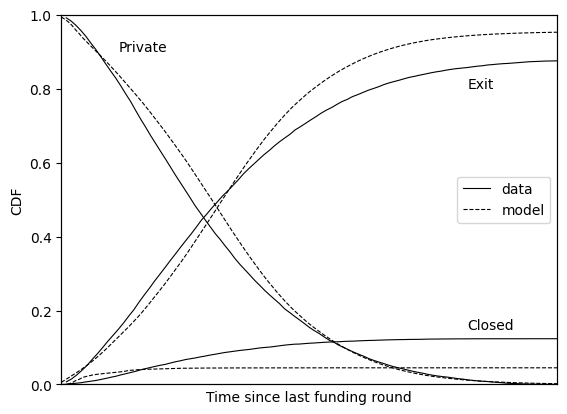

In [3]:
from scripts.sim import sim
from pickle import load
from scripts.preprocess import load_index_data, load_tbills_data

logrf = load_tbills_data('TB3MS', '2010-01-01', '2022-03-01').iloc[:,0].values
logmk = load_index_data('^SP500TR', '2010-01-01', '2022-03-02', '1mo', prefix='../../').values
logrf = np.repeat(logrf.reshape(-1,1), 3, axis=1).reshape(-1)


# parameters for baseline sp500
c, d = 1, 0.39
start, end, pred = load(open('../results/res_from_2010.pkl', 'rb')).values()
gamma, delta, sigma, k, a, b, pi_err = pred.loc['value']
logv = np.arange(-7, 7.1, 0.1)
sim_params = [gamma, delta, sigma, k, a, b, c, d, pi_err, 1, logrf, logmk, logv, 1, 1, 0, 148]
prob_pvt, prob_ipo_obs, prob_ipo_hid, prob_bkp_obs, prob_bkp_hid = sim(*sim_params)

prob_exit = prob_ipo_obs.sum(axis=1) + prob_ipo_hid
prob_bankrupt = prob_bkp_obs + prob_bkp_hid
prob_private = prob_pvt

draw_simulation_graph(prob_exit, prob_bankrupt, prob_private)
plt.show()

In [102]:
from scripts.utils import display_return_stats
from scripts.preprocess import load_venture_data
import pandas as pd


def compute_stats(data):
    c, d = display_return_stats(data, False)
    df = {
        'Number': data.shape[0],
        'IPO': data[data.exit_type == 1].shape[0],
        'Acq.': data[data.exit_type == 2].shape[0],
        'Closed': data[data.exit_type == 3].shape[0],
        'Private': data[data.exit_type == 4].shape[0],
        'd': d * 100
    }
    
    return pd.Series(df).astype(int)


x = load_venture_data(prefix='../../')
nbr = x.groupby('company_num').size()

stats = pd.concat([
    compute_stats(x),
    compute_stats(x[x.company_num.isin(nbr[nbr == 1].index)]),
    compute_stats(x[x.company_num.isin(nbr[nbr == 2].index)]),
    compute_stats(x[x.company_num.isin(nbr[nbr == 3].index)]),
    compute_stats(x[x.company_num.isin(nbr[nbr > 3].index)]),
    compute_stats(x[x.group_num == 'Tech']),
    compute_stats(x[x.group_num == 'Retail']),
    compute_stats(x[x.group_num == 'Health']),
    compute_stats(x[x.group_num == 'Other'])
    ], axis=1)

stats.columns = ['All', '1', '2', '3', '+4', 'Tech', 'Retail', 'Health', 'Other']
stats.to_excel('../../data/stats_full.xlsx', index=False)
stats

AssertionError: 

In [2]:
x = load_venture_data(pred=False, prefix='../../')
nbr = x.groupby('company_num').size()

stats = pd.concat([
    compute_stats(x),
    compute_stats(x[x.company_num.isin(nbr[nbr == 1].index)]),
    compute_stats(x[x.company_num.isin(nbr[nbr == 2].index)]),
    compute_stats(x[x.company_num.isin(nbr[nbr == 3].index)]),
    compute_stats(x[x.company_num.isin(nbr[nbr > 3].index)]),
    compute_stats(x[x.group_num == 'Tech']),
    compute_stats(x[x.group_num == 'Retail']),
    compute_stats(x[x.group_num == 'Health']),
    compute_stats(x[x.group_num == 'Other'])
    ], axis=1)

stats.columns = ['All', '1', '2', '3', '+4', 'Tech', 'Retail', 'Health', 'Other']
stats.to_excel('../../data/stats_nopred.xlsx', index=False)
stats

loading no predictions dataset


,All,1,2,3,+4,Tech,Retail,Health,Other
Number,119436,49297,29870,18006,22263,81066,19612,6532,12226
IPO,6003,1157,1196,1086,2564,4609,798,160,436
Acq.,15015,5347,4226,2631,2811,10368,2381,541,1725
Closed,3598,1698,1046,525,329,2303,574,119,602
Private,94820,41095,23402,13764,16559,63786,15859,5712,9463
d,2,1,1,2,4,2,3,2,1


# Comparison to know index

In [13]:
import yfinance as yf
from sklearn.linear_model import LinearRegression

trvci = pd.read_excel('../../data/Price History_20220721_1403.xlsx', 
                      skiprows=17, usecols='A:D', parse_dates=True)
trvci = trvci.sort_values(by='Exchange Date')
trvci = trvci.set_index('Exchange Date')

y = trvci['Close'].pct_change().dropna()
y = y[y.index.isin(x.index)]


benchmark = '^SP500TR'
sp500 = yf.download(tickers=benchmark, start=trvci.index[0] + pd.DateOffset(1), end=trvci.index[-1] + pd.DateOffset(1))

lm500 = LinearRegression()
lm500.fit(sp500['Adj Close'].pct_change().dropna().values.reshape(-1, 1), y)


benchmark = '^IXIC'
ndq = yf.download(tickers=benchmark, start=trvci.index[0] + pd.DateOffset(1), end=trvci.index[-1] + pd.DateOffset(1))

lmNDQ = LinearRegression()
lmNDQ.fit(ndq['Adj Close'].pct_change().dropna().values.reshape(-1, 1), y)


benchmark = '^RUT'
rut = yf.download(tickers=benchmark, start=trvci.index[0] + pd.DateOffset(1), end=trvci.index[-1] + pd.DateOffset(1))

lmRUT = LinearRegression()
lmRUT.fit(rut['Adj Close'].pct_change().dropna().values.reshape(-1, 1), y)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


LinearRegression()

In [14]:
print(f"SP500TR: alpha={lm500.intercept_:.2e}, beta={lm500.coef_[0]:.2f}")
print(f"NASDAQ: alpha={lmNDQ.intercept_:.2e}, beta={lmNDQ.coef_[0]:.2f}")
print(f"RUSSEL: alpha={lmRUT.intercept_:.2e}, beta={lmRUT.coef_[0]:.2f}")

SP500TR: alpha=6.38e-05, beta=1.56
NASDAQ: alpha=-7.83e-06, beta=1.50
RUSSEL: alpha=4.76e-04, beta=1.03


In [103]:
from scripts.preprocess import load_venture_data

rets = load_venture_data(pred=True, prefix='../../')

Loading full dataset... Done.


In [9]:
import pandas as pd
import seaborn as sns

ipos = pd.read_csv('../../data/crunchbase/ipos.csv')
exits = ipos.set_index('org_uuid')[['went_public_on', 'stock_symbol']]
exits.index.name = 'uuid'

orgs = pd.read_csv('../../data/crunchbase/organizations.csv')
created = orgs.set_index('uuid')['founded_on']

In [10]:
dates = pd.merge(created, exits, on='uuid', how='left').dropna()
dates[['founded_on', 'went_public_on']] = dates[['founded_on', 'went_public_on']].apply(pd.to_datetime, errors='coerce')
dates = dates[dates.founded_on > pd.to_datetime('1960-01-01')]

In [11]:
dates['days_before_ipo'] = (dates.went_public_on - dates.founded_on).dt.days
dates = dates[dates.days_before_ipo > 0]

<AxesSubplot:xlabel='days_before_ipo', ylabel='Count'>

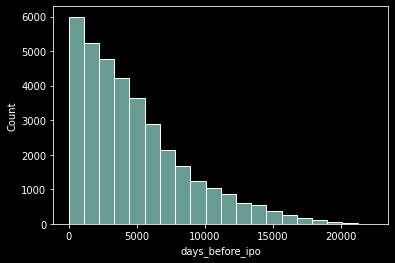

In [14]:
x = dates.sort_values(by='founded_on')
sns.histplot(x.days_before_ipo, bins=20)

In [15]:
dates.iloc[0,2] = 'META'

In [16]:
dates

,founded_on,went_public_on,stock_symbol,days_before_ipo
uuid,,,,
df662812-7f97-0b43-9d3e-12f64f504fbb,2004-02-04,2012-05-18,META,3026
5da6106f-0d27-0d37-e9d7-dcfeccc1f709,2006-03-21,2013-11-07,TWTR,2788
e56b0ceb-bb30-bbec-805e-d5dc7412dcb1,1995-09-01,1998-09-24,EBAY,1119
4522b60d-0b04-827e-2b6c-6eaf236cf636,1971-01-01,2005-12-16,VIAB,12768
e0906c05-fae5-9591-ba5f-2142d8b0065a,1984-12-01,1990-02-23,CSCO,1910
...,...,...,...,...
e1ddb3a5-193d-487a-864f-bd10ff05dab4,2015-01-01,2022-06-15,LYT,2722
4c7c6f11-8e67-4f5f-97cd-96505746dee8,1997-01-01,2022-06-22,GSUN,9303
128f9ebd-e846-4329-b4b3-9fd51cc09233,2019-01-01,2021-06-11,TOIVO,892


In [17]:
import yfinance as yf
from tqdm import tqdm
import numpy as np
from pandas_datareader import data

def get_caps(symbol):
    try:
        market_cap = int(data.get_quote_yahoo(symbol)['marketCap'])
    except:
        market_cap = np.nan
    return {symbol: market_cap}

# Cybersecurity

In [17]:
path = '../../data/data.csv'
returns = pd.read_csv(path, low_memory=False)

In [20]:
orgs = pd.read_csv('../../data/crunchbase/organizations.csv')

In [21]:
cats = orgs[orgs.uuid.isin(returns.company_num)][['uuid', 'category_groups_list']].dropna()
cats.category_groups_list = cats.category_groups_list.apply(lambda x: x.split(','))
cats.columns = ['org_uuid', 'category']

In [27]:
security = ['Information Technology', 'Network Security', 
 'Cyber Security', 'Security', 'IT Infrastructure',
 'Drones', 'National Security', 'Peer to Peer',
 'Blockchain', 'Privacy', 'Cloud Security', 'Homeland Security',
 'Fraud Detection', 'Spam Filtering', 'Intrusion Detection']

In [33]:
segments = orgs[['uuid', 'category_list']].dropna()
segments.category_list = segments.category_list.apply(lambda x: x.split(','))

In [67]:
security_orgs = segments[segments.apply(lambda row: any([x in security for x in row.category_list]), axis=1)]
security_returns = returns[returns.company_num.isin(security_orgs.uuid)]

In [68]:
print(f"Found {security_orgs.shape[0]} IT security firms in total")
print(f"Found {security_returns.shape[0]} IT security firms with financial data")

Found 281861 IT security firms in total
Found 21129 IT security firms with financial data


In [69]:
security_returns.to_csv('../../data/security_data.csv', index=False)